In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
from tqdm.auto import tqdm

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
dt = 1/128

# load all data

In [5]:
data_dir = '/om/user/eisenaj/datasets/DASPS_Database/'

In [6]:
response_df = pd.read_excel(os.path.join(data_dir, 'participant_rating_public.xlsx'))
response_df = response_df.drop('Unnamed: 0', axis=1)

In [7]:
response_df['anxious'] = [None]*len(response_df)
anxious = np.zeros((23, 6))
anxiety_level = np.zeros((23, 6))
response_df['anxiety_level'] = [None]*len(response_df)
for i in range(len(response_df)):
    if not isinstance(response_df.loc[i]['Id Participant'], str):
        response_df.loc[i, 'Id Participant'] = response_df.loc[i - 1]['Id Participant']
        response_df.loc[i, 'Hmilton1'] = response_df.loc[i-1, 'Hmilton1']
        response_df.loc[i, 'Hamilton2'] = response_df.loc[i-1, 'Hamilton2']
    subject_num = int(response_df.loc[i, "Id Participant"][1:])
    situation_num = int(response_df.loc[i, "Id situation "])
    
    valence = response_df.loc[i,'valence']
    arousal = response_df.loc[i, 'Arousal']
    response_df.loc[i, 'anxious'] = True if valence < 5 and arousal > 5 else False
    
    
    if not response_df.loc[i, 'anxious']:
        response_df.loc[i, 'anxiety_level'] = None
        anxious[subject_num-1, situation_num-1] = 0
        anxiety_level[subject_num-1, situation_num-1] = 0
    else:
        anxious[subject_num-1, situation_num-1] = 1
        if valence in [0, 1, 2] and arousal in [7, 8, 9]:
            response_df.loc[i, 'anxiety_level'] = 'severe'
            anxiety_level[subject_num-1, situation_num-1] = 4
        elif valence in [2, 3, 4] and arousal in [6, 7]:
            response_df.loc[i, 'anxiety_level'] = 'moderate'
            anxiety_level[subject_num-1, situation_num-1] = 2
        elif valence in [4, 5] and arousal in [5, 6]:
            response_df.loc[i, 'anxiety_level'] = 'light'
            anxiety_level[subject_num-1, situation_num-1] = 1
        else:
            response_df.loc[i, 'anxiety_level'] = 'normal'
            anxiety_level[subject_num-1, situation_num-1] = 3

In [8]:
data = np.zeros((23, 6, 30*128, 14))
for subject_num in range(1, 24):
    for situation_num in range(1, 7):
        f = h5py.File(os.path.join(data_dir, f"Preprocessed data .mat/S{subject_num:02d}preprocessed.mat"), 'r')
#         f = h5py.File(os.path.join(data_dir, f"Raw data.mat/S{subject_num:02d}.mat", 'r'))
        t = np.arange(f['data'].shape[1]*2)*dt
        data[subject_num-1, situation_num-1] = np.vstack([f['data'][(situation_num-1)*2, :, :], f['data'][(situation_num-1)*2 + 1, :, :]])

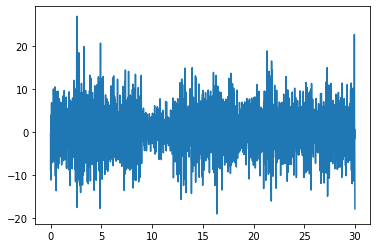

In [9]:
subject_num = 5
situation_num = 1
electrode_num = 0
plt.plot(np.arange(0, 30, 1/128), data[subject_num-1, situation_num-1, :, electrode_num])
# plt.plot(butter_bandpass_filter(data[subject_num-1, situation_num-1, :, electrode_num], 0.4, 50, fs=1/dt))
plt.show()

# process all data

In [15]:
window_s = 0.25
# stride_s = window_s
stride_s = 0.25
window = int(window_s/dt)
stride = int(stride_s/dt)
# num_windows = int(data.shape[2]/stride)
num_windows = int(np.floor((data.shape[2]-window)/stride))+1
area = 'frontal'

if area == 'all':
    area_inds = np.arange(14)
elif area == 'frontal':
    area_inds = np.arange(8)
else:
    raise ValueError(f"Area {area} is not allowed!")

all_window_data = []
criticality_inds = np.zeros((23, 6, num_windows, len(area_inds)))

iterator = tqdm(total = 23*6*num_windows)

for subject_num in range(1, 24):
    for situation_num in range(1, 7):
        for i in range(num_windows):
            window_data = {}
            chunk = data[subject_num-1, situation_num-1, i*stride:i*stride + window, area_inds]
            chunk = chunk.T
            model = VAR(chunk)
            VAR_results = model.fit(1)
            window_data['A_mat'] = VAR_results.coefs[0]
            window_data['A_mat_with_bias'] = VAR_results.params
            e,_ = np.linalg.eig(VAR_results.coefs[0])   
            window_data['eigs'] = e   
            window_data['criticality_inds'] = np.abs(e)

            window_data['sigma2_ML'] = np.linalg.norm(VAR_results.endog[1:] - (VAR_results.endog_lagged @ VAR_results.params), axis=1).sum()/(window- 2)
            window_data['AIC'] = window*np.log(window_data['sigma2_ML']) + 2
            window_data['sigma_norm'] = np.linalg.norm(VAR_results.sigma_u, ord=2)

            window_data['subject_num'] = subject_num
            window_data['situation_num'] = situation_num
            window_data['window_num'] = i
            
            all_window_data.append(window_data)
            criticality_inds[subject_num-1, situation_num-1, i] = window_data['criticality_inds']
        
            iterator.update()
iterator.close()

  0%|          | 0/16560 [00:00<?, ?it/s]

In [16]:
# # normalize by participant
# for i in range(23):
#     mu = criticality_inds[i].mean()
#     sigma = criticality_inds[i].std()
    
#     criticality_inds[i] = (criticality_inds[i] - mu)/sigma

In [17]:
anxious_inds = []
normal_inds = []
for i in range(23):
    for j in range(6):
        if anxious[i, j]:
            anxious_inds.extend(criticality_inds[i, j].flatten())
        else:
            normal_inds.extend(criticality_inds[i, j].flatten())
anxious_inds = np.array(anxious_inds)
normal_inds = np.array(normal_inds)

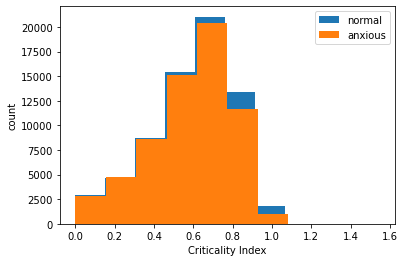

In [18]:
plt.hist(normal_inds, label='normal')
plt.hist(anxious_inds, label='anxious')
plt.xlabel("Criticality Index")
plt.ylabel("count")
plt.legend()
plt.show()

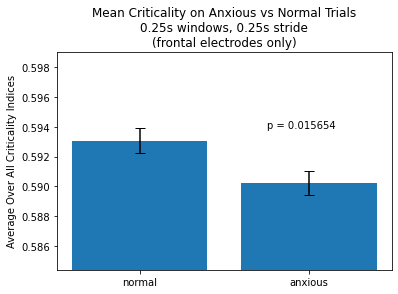

In [19]:
std_errors = [anxious_inds.std()/np.sqrt(len(anxious_inds)), normal_inds.std()/np.sqrt(len(normal_inds))]
mean_vals = [normal_inds.mean(), anxious_inds.mean()]
# t-test
n1 = len(anxious_inds)
n2 = len(normal_inds)
mean_1 = mean_vals[0]
mean_2 = mean_vals[1]
var_1 = (anxious_inds.std())**2
var_2 = (normal_inds.std())**2
s_squared = (n1 - 1)/(n1 + n2 - 2)*var_1 + (n2 - 1)/(n1 + n2 - 2)*var_2
t_stat = (mean_1 - mean_2)/(np.sqrt(s_squared)*np.sqrt((1/n1) + (1/n2)))
p = 2*scipy.stats.t.sf(t_stat, df=n1 + n2 - 2)

plt.bar(['normal', 'anxious'], mean_vals, yerr=std_errors, capsize=5)
plt.ylim([np.min(mean_vals)*(1/1.01), np.max(mean_vals)*(1.01)])
plt.text(0.75, mean_vals[0] + 1*std_errors[0], f"p = {p:.6f}" if p > 0.0001 else f"p = {p:.2e}")
plt.ylabel("Average Over All Criticality Indices")
plt.title(f"Mean Criticality on Anxious vs Normal Trials\n{window_s}s windows, {stride_s}s stride" + ("\n(frontal electrodes only)" if area == 'frontal' else ""))
plt.show()

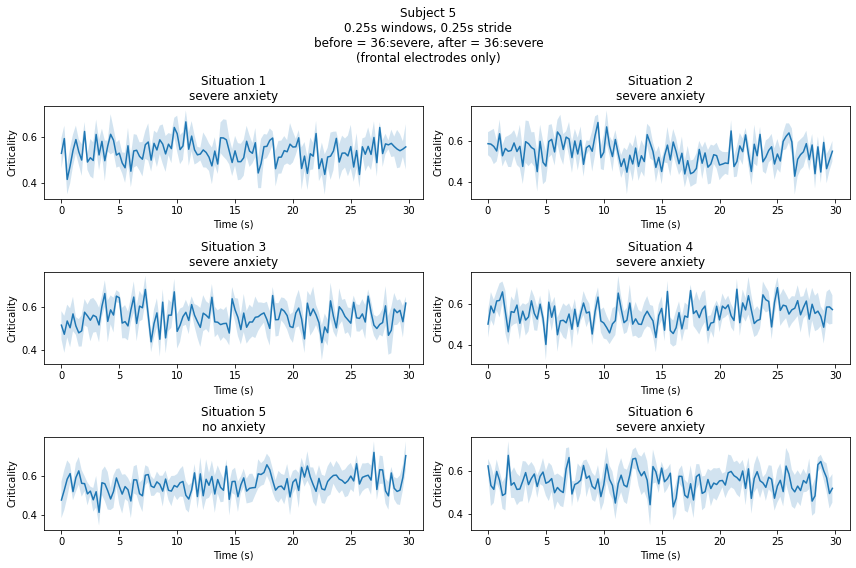

In [21]:
subject_num = 5

rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

for situation_num in range(1, 7):
    ax = axs[int((situation_num - 1)/cols)][(situation_num - 1)%cols]
    row = response_df[np.logical_and(response_df['Id Participant'] == f"S{subject_num:02d}", response_df['Id situation '] == situation_num)].iloc[0]
    t = np.arange(num_windows)*stride_s
    mean_CIs = criticality_inds[subject_num-1, situation_num-1].mean(axis=1)
    stderr_CIs = criticality_inds[subject_num-1, situation_num-1].std(axis=1)/np.sqrt(criticality_inds.shape[3])
    ax.plot(t, mean_CIs)
    ax.fill_between(t, mean_CIs - stderr_CIs, mean_CIs + stderr_CIs, alpha=0.2)
    ax.set_xlabel("Time (s)")
    anxiety_add_on = f"{row.anxiety_level} anxiety" if row.anxious else "no anxiety"
    ax.set_title(f"Situation {situation_num}\n{anxiety_add_on}")
    ax.set_ylabel("Criticality")
plt.suptitle(f"Subject {subject_num}\n{window_s}s windows, {stride_s}s stride\nbefore = {row.Hmilton1}, after = {row.Hamilton2}" + ("\n(frontal electrodes only)" if area == 'frontal' else ""))
plt.tight_layout()
plt.show()

In [18]:
# subject_num = 18
# situation_num = 2

# # plt.plot(t, data[:, 0])
# # plt.xlabel("Time (ms)")
# # plt.show()

# row = response_df[np.logical_and(response_df['Id Participant'] == f"S{subject_num:02d}", response_df['Id situation '] == situation_num)].iloc[0]
# t = np.arange(num_windows)*stride_s
# mean_CIs = criticality_inds[subject_num-1, situation_num-1].mean(axis=1)
# stderr_CIs = criticality_inds[subject_num-1, situation_num-1].std(axis=1)/np.sqrt(criticality_inds.shape[3])
# plt.plot(t, mean_CIs)
# plt.fill_between(t, mean_CIs - stderr_CIs, mean_CIs + stderr_CIs, alpha=0.2)
# plt.xlabel("Time (s)")
# anxiety_add_on = f"{row.anxiety_level} anxiety" if row.anxious else "no anxiety"
# plt.title(f"Subject {subject_num} Situation {situation_num}\n{window_s}s windows, {stride_s}s stride\n{anxiety_add_on}")
# plt.ylabel("Criticality")
# plt.show()

# test different window sizes

In [218]:
all_dfs = {}
windows = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
for window_s in windows:
    print(f"Now computing window {window_s}")
#     window_s = 2.5
    stride_s = window_s
#     stride_s = 2.5

    window = int(window_s/dt)
    stride = int(stride_s/dt)
    # num_windows = int(data.shape[2]/stride)
    num_windows = int(np.floor((data.shape[2]-window)/stride))+1
    area = 'frontal'

    if area == 'all':
        area_inds = np.arange(14)
    elif area == 'frontal':
        area_inds = np.arange(8)
    else:
        raise ValueError(f"Area {area} is not allowed!")

    all_window_data = []
    criticality_inds = np.zeros((23, 6, num_windows, len(area_inds)))

    iterator = tqdm(total = 23*6*num_windows)

    T_pred = 10
    for subject_num in range(1, 24):
        for situation_num in range(1, 7):
            for i in range(num_windows):
                window_data = {}
                chunk = data[subject_num-1, situation_num-1, i*stride:i*stride + window, area_inds]
                chunk = chunk.T

                model = VAR(chunk)
                VAR_results = model.fit(1)
                window_data['A_mat'] = VAR_results.coefs[0]
                window_data['A_mat_with_bias'] = VAR_results.params
                e,_ = np.linalg.eig(VAR_results.coefs[0])   
                window_data['eigs'] = e   
                window_data['criticality_inds'] = np.abs(e)

                window_data['sigma2_ML'] = np.linalg.norm(VAR_results.endog[1:] - (VAR_results.endog_lagged @ VAR_results.params), axis=1).sum()/(window- 2)
                window_data['AIC'] = window*np.log(window_data['sigma2_ML']) + 2
                window_data['sigma_norm'] = np.linalg.norm(VAR_results.sigma_u, ord=2)

                window_data['subject_num'] = subject_num
                window_data['situation_num'] = situation_num
                window_data['window_num'] = i

                if i*stride + window + T_pred <= data.shape[2]:
                    x0 = chunk[-1]
                    predictions = np.zeros((T_pred, len(area_inds)))
                    for t in range(T_pred):
                        if t == 0:
                            predictions[t] = np.hstack([[1], x0]) @ window_data['A_mat_with_bias']
                        else:
                            predictions[t] = np.hstack([[1], predictions[t - 1]]) @ window_data['A_mat_with_bias']

                    true_vals = data[subject_num-1, situation_num-1, i*stride + window:i*stride + window + T_pred, area_inds]
                    true_vals = true_vals.T

                    window_data['predictions'] = predictions
                    window_data['true_vals'] = true_vals
                    window_data['step_mse'] = ((predictions - true_vals)**2).mean(axis=1)
                else:
                    window_data['predictions'] = None
                    window_data['true_vals'] = None
                    window_data['step_mse'] = None

                all_window_data.append(window_data)
                criticality_inds[subject_num-1, situation_num-1, i] = window_data['criticality_inds']

                iterator.update()
    iterator.close()
    all_dfs[window_s] = pd.DataFrame(all_window_data)

Now computing window 0.5



Now computing window 1



Now computing window 1.5



Now computing window 2



Now computing window 2.5



Now computing window 3



Now computing window 3.5



Now computing window 4



Now computing window 4.5



Now computing window 5



Now computing window 5.5



Now computing window 6



Now computing window 6.5



Now computing window 7



Now computing window 7.5



Now computing window 8



Now computing window 8.5



Now computing window 9



Now computing window 9.5



Now computing window 10


In [219]:
# steps = np.array([10]) - 1
steps = np.arange(10)
mse = np.zeros(len(windows))
for i, window_s in enumerate(windows):
    mses = all_dfs[window_s].step_mse.apply(lambda x: x[steps] if x is not None else None)
    mse[i] = mses[mses.apply(lambda x: x is not None)].apply(lambda x: x.mean()).mean()

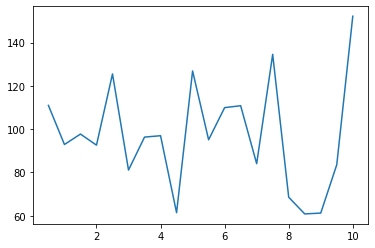

In [220]:
plt.plot(windows, mse)
plt.show()

# Correlations

In [64]:
print("Anxiety correlated with mean, final, max, min")
print(pearsonr(criticality_inds.mean(axis=3).mean(axis=2).flatten(), anxious.flatten()))
print(pearsonr(criticality_inds.mean(axis=3)[:, :, -1].flatten(), anxious.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).max(axis=2).flatten(), anxious.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).min(axis=2).flatten(), anxious.flatten()))

print("Anxiety level correlated with mean, final, max, min")
print(pearsonr(criticality_inds.mean(axis=3).mean(axis=2).flatten(), anxiety_level.flatten()))
print(pearsonr(criticality_inds.mean(axis=3)[:, :, -1].flatten(), anxiety_level.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).max(axis=2).flatten(), anxiety_level.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).min(axis=2).flatten(), anxiety_level.flatten()))

Anxiety correlated with mean, final, max, min
(-0.01754723447952046, 0.8381393249954477)
(-0.14072310958547982, 0.09970439351144252)
(-0.022786016034584425, 0.7907978007299753)
(-0.006786735006887288, 0.9370311861879346)
Anxiety level correlated with mean, final, max, min
(-0.021512672768070874, 0.8022417084184161)
(-0.14735068249381506, 0.08458859470544755)
(-0.029036687162219015, 0.7353085673627309)
(0.0005397554011503103, 0.9949869116508522)


In [341]:
print("Anxiety correlated with mean, final, max, min")
print(pearsonr(criticality_inds.mean(axis=3).mean(axis=2).flatten(), anxious.flatten()))
print(pearsonr(criticality_inds.mean(axis=3)[:, :, -1].flatten(), anxious.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).max(axis=2).flatten(), anxious.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).min(axis=2).flatten(), anxious.flatten()))

print("Anxiety level correlated with mean, final, max, min")
print(pearsonr(criticality_inds.mean(axis=3).mean(axis=2).flatten(), anxiety_level.flatten()))
print(pearsonr(criticality_inds.mean(axis=3)[:, :, -1].flatten(), anxiety_level.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).max(axis=2).flatten(), anxiety_level.flatten()))
print(pearsonr(criticality_inds.mean(axis=3).min(axis=2).flatten(), anxiety_level.flatten()))

Anxiety correlated with mean, final, max, min
(-0.051591310926628914, 0.5478743628298129)
(-0.12450888594722728, 0.14566587063757366)
(-0.06978026764321021, 0.416064258492749)
(0.035828186631558866, 0.6765383178999301)
Anxiety level correlated with mean, final, max, min
(-0.04526910778996117, 0.5980374409664913)
(-0.1288965212448186, 0.13188477587294944)
(-0.06138728444947836, 0.4744528217589379)
(0.03705368550465403, 0.6661258104396939)
